In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import os
import collections
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pymir import mpl_stylesheet
from pymir import mpl_utils
from pymir import pd_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

In [2]:
dscout = pd.read_pickle("../dsc/results/linreg_indep_dscout.pkl")

In [3]:
# methods in the simulation

dims = [(50, 10000),]
sfixs = [1, 2, 5, 10, 20,]
method_groups = {
    'PLR': ["ridge", "lasso", "elastic_net", 
            "lasso_1se", "elastic_net_1se", 
            "scad", "mcp", "l0learn"],
    'Sampling': ["blasso", "bayesb"],
    'CAVI': ["mr_ash", "mr_ash_lasso_init", "varbvs", "varbvsmix", "susie"],
    'GradVI': ["gradvi_direct", "gradvi_compound"],
}

In [4]:
# method_groups = {
#     'PLR': ["ridge", "lasso"],
#     'CAVI': ["mr_ash",],
#     'GradVI': ["gradvi_direct", "gradvi_compound"],
# }

method_groups = {
    'PLR': ["lasso", "elastic_net", 
            "lasso_1se", "elastic_net_1se", 
            "scad", "mcp", "l0learn"],
    'Sampling': ["bayesb"],
    'CAVI': ["mr_ash", "mr_ash_lasso_init", "varbvs", "varbvsmix", "susie"],
    'GradVI': ["gradvi_direct", "gradvi_compound"],
}

methods = [method for k, v in method_groups.items() for method in v]

In [5]:
dscout

,DSC,simulate,simulate.dims,simulate.se,simulate.rho,simulate.sfix,simulate.pve,fit,fit.DSC_TIME,mse.err,coef_mse.err
0,1,equicorrgauss,"(500,10000)",0.615635,0,1,0.4,susie,11.978,0.381405,NaN
1,1,equicorrgauss,"(500,10000)",3.165824,0,2,0.4,susie,14.510,10.878477,NaN
2,1,equicorrgauss,"(500,10000)",2.906543,0,5,0.4,susie,12.660,8.510282,NaN
3,1,equicorrgauss,"(500,10000)",2.234618,0,10,0.4,susie,15.675,5.473055,NaN
4,1,equicorrgauss,"(500,10000)",6.718919,0,20,0.4,susie,20.271,57.600500,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5095,10,equicorrgauss,"(500,10000)",0.061956,0,1,0.8,l0learn,25.538,NaN,2.993806e-10
5096,10,equicorrgauss,"(500,10000)",0.349102,0,2,0.8,l0learn,23.217,NaN,7.787907e-07
5097,10,equicorrgauss,"(500,10000)",1.330043,0,5,0.8,l0learn,19.683,NaN,1.138709e-05
5098,10,equicorrgauss,"(500,10000)",1.169124,0,10,0.8,l0learn,21.903,NaN,8.751058e-06


In [6]:
method = 'gradvi_compound'
colname = 'mse.err'

mconditions = [f"$(fit) == {method}", f"$(simulate.sfix) == 1", f"$(simulate.pve) == 0.6"]
dfm = pd_utils.select_dfrows(dscout, mconditions)
dfs = dfm[~dfm[colname].isnull()]

dfs

,DSC,simulate,simulate.dims,simulate.se,simulate.rho,simulate.sfix,simulate.pve,fit,fit.DSC_TIME,mse.err,coef_mse.err
2405,1,equicorrgauss,"(500,10000)",0.375810,0,1,0.6,gradvi_compound,395.208650,0.152670,NaN
2420,2,equicorrgauss,"(500,10000)",0.079163,0,1,0.6,gradvi_compound,293.480566,0.006417,NaN
2435,3,equicorrgauss,"(500,10000)",0.195774,0,1,0.6,gradvi_compound,425.995533,0.041126,NaN
2450,4,equicorrgauss,"(500,10000)",0.984131,0,1,0.6,gradvi_compound,219.923923,0.998943,NaN
2465,5,equicorrgauss,"(500,10000)",0.141848,0,1,0.6,gradvi_compound,472.166881,0.019824,NaN
2480,6,equicorrgauss,"(500,10000)",1.084043,0,1,0.6,gradvi_compound,13.831409,2.932694,NaN
2495,7,equicorrgauss,"(500,10000)",0.479687,0,1,0.6,gradvi_compound,366.605546,0.241594,NaN
2510,8,equicorrgauss,"(500,10000)",0.178197,0,1,0.6,gradvi_compound,524.471917,0.031911,NaN
2525,9,equicorrgauss,"(500,10000)",1.481401,0,1,0.6,gradvi_compound,176.147315,2.206482,NaN
2540,10,equicorrgauss,"(500,10000)",0.333635,0,1,0.6,gradvi_compound,325.674678,0.114405,NaN


In [7]:
debug_maxscore = False

if debug_maxscore:
    idx = np.argmax(score_factory(dfs))
    _mdfs = dfs.iloc[[idx]]
    print ("Index", idx)
    print ("MSE: ", _mdfs['mse.err'].iloc[0])
    print ("SE:  ", _mdfs['simulate.se'].iloc[0])
    print ("PVE: ", _mdfs['simulate.pve'].iloc[0])

    _maxscore = np.sqrt(_mdfs['mse.err']) * np.sqrt(1 - _mdfs['simulate.pve']) / np.sqrt(1000) / _mdfs['simulate.se']
    print("Scaled RMSE: ", _maxscore.iloc[0])

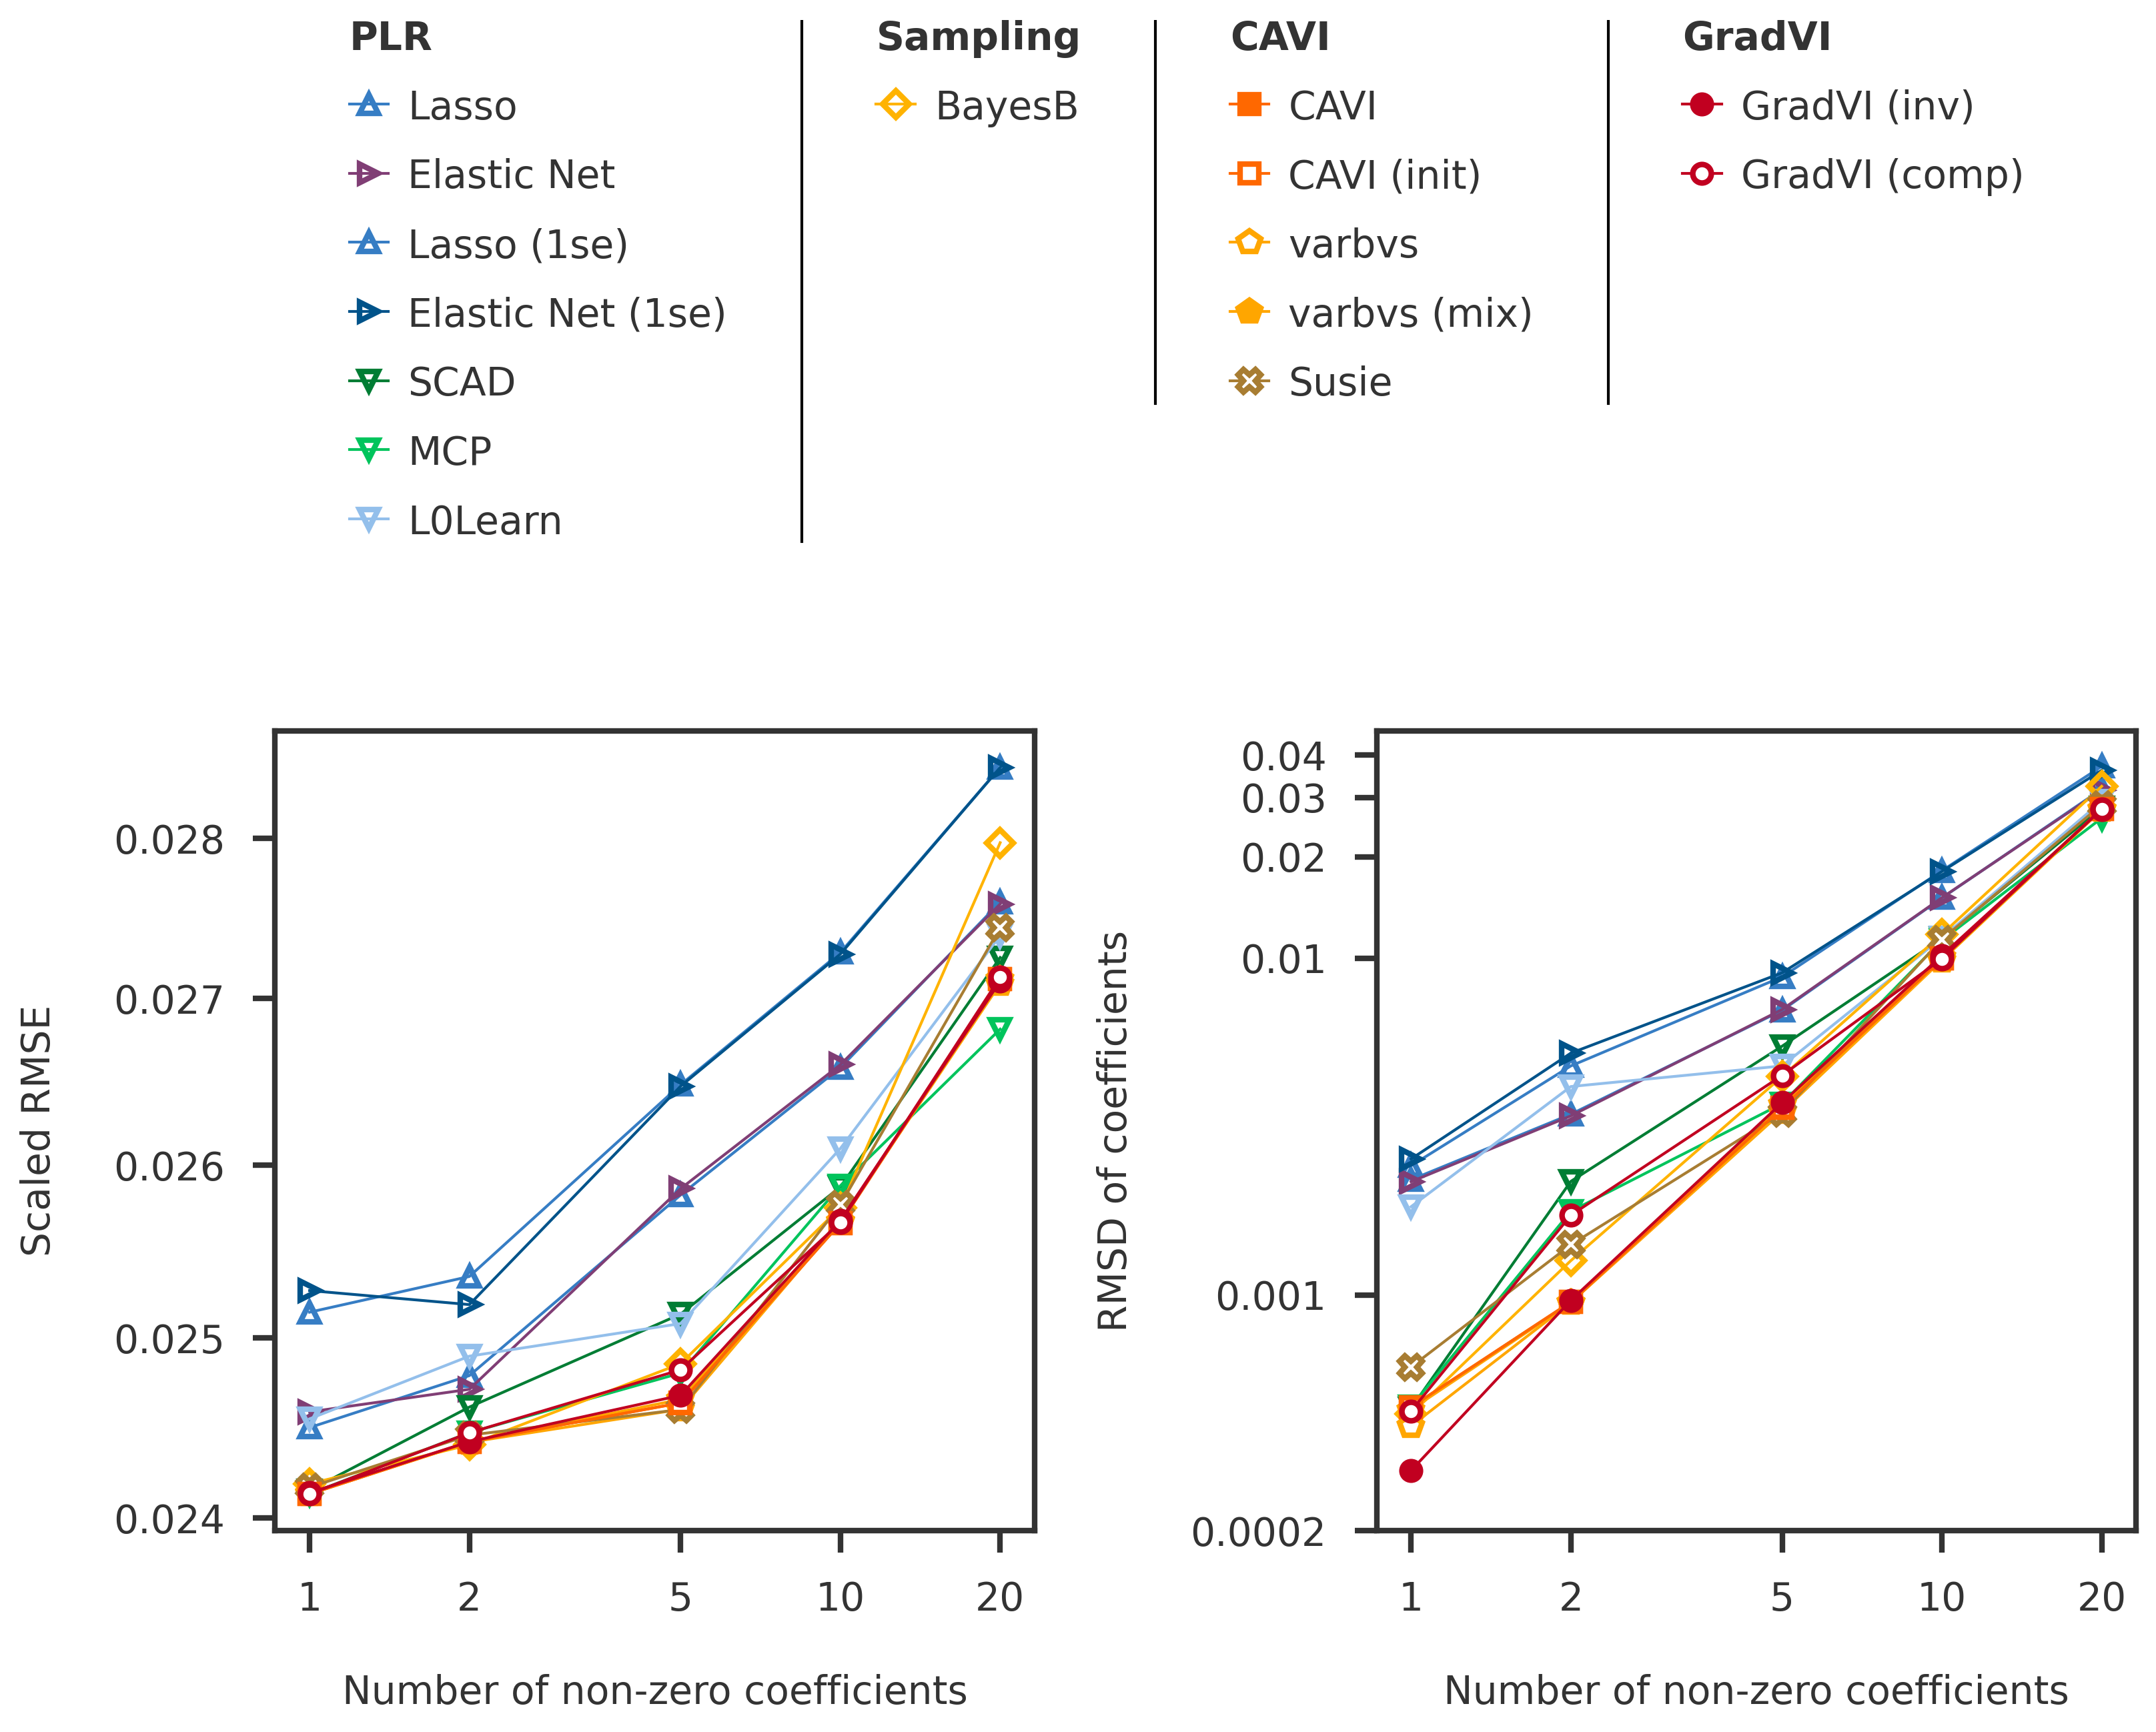

In [8]:
import methodprops

def scaled_rmse(mse, std, pve, n = 1000):
    rmse = np.sqrt(np.array(mse)) / np.sqrt(n)
    scale = np.array(std) / np.sqrt(1 - np.array(pve))
    return rmse / scale

def score_factory(df, method = 'scaled_rmse', ntest = 1000):
    if method == 'scaled_rmse':
        dfs = df[~df['mse.err'].isnull()]
        score = scaled_rmse(dfs['mse.err'], dfs['simulate.se'], dfs['simulate.pve'])
        return score
    elif method == 'scaled_coef_rmse':
        dfs = df[~df['coef_mse.err'].isnull()]
        score = np.sqrt(dfs['coef_mse.err'].to_numpy()) #/ np.sqrt(ntest)
        return score
    return np.array([0.])


def single_plot_method(ax, x, xscale, y, yscale, method):
    pm = methodprops.plot_metainfo()[method]
    ax.plot(
        mpl_utils.scale_array(x, xscale), 
        mpl_utils.scale_array(y, yscale), 
        label = pm.label, color = pm.color, lw = pm.linewidth / 2, 
        ls = pm.linestyle, marker = pm.marker, ms = pm.size / 1.2, 
        mec = pm.color, mfc = pm.facecolor, mew = pm.linewidth,
        zorder = pm.zorder)
    return


def stratify_dfcol(df, colname, value):
    return df.loc[df[colname] == value]


def axplot_methods_colname_score(ax, resdf, methods, whichcol, whichscore):
    
    xscale   = 'linear'
    if whichcol in ['simulate.sfix']:
        xscale = 'log10'
        
    yscale   = 'log10'
    values   = np.array(sorted(list(set(dscout[whichcol].to_list()))))

    for method in methods:        
        dfm = stratify_dfcol(resdf, 'fit', method)
        
        scores = [np.median(score_factory(stratify_dfcol(dfm, whichcol, v), method = whichscore))
                  for v in values]
        
        single_plot_method(ax, values, xscale, scores, yscale, method)
        
    mpl_utils.set_yticks(ax, scale = yscale, spacing = 'linear', fmt = '{:.3f}')
    mpl_utils.set_xticks(ax, scale = xscale, spacing = 'log10', tickmarks = values)
    return

def axis_with_legend_columns(
    fig, ax, method_groups, mhandles, mlabels, 
    frameon = False, show_axes = False, xpad = 0.04
    ):
    #
    renderer = fig.canvas.get_renderer()
    ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
    plotmeta = methodprops.plot_metainfo()
    ncol     = len(method_groups)
    xleg     = 0
    
    for k, (group, methods) in enumerate(method_groups.items()):
        _idx     = [mlabels.index(plotmeta[m].label) for m in methods]
        _labels  = [mlabels[i]  for i in _idx]
        _handles = [mhandles[i] for i in _idx]
        
        legend = ax.legend(
            handles = _handles, labels = _labels, title = group,
            title_fontproperties={'weight':'bold'},
            loc = 'upper left', bbox_to_anchor = (xleg + xpad, 1.0),
            frameon = frameon, framealpha = 1.0, borderpad = 0.0, borderaxespad = 0.0
        )
        
        # align column titles to left
        legend._legend_box.align = "left"

        # corners should be square (not round)
        legend.get_frame().set_boxstyle('square', pad = 0.0)

        # add artist for all but last legend
        if k < ncol - 1:
            ax.add_artist(legend)

        # Get width of the legend
        fig.canvas.draw()
        legbbox = legend.get_window_extent(renderer).transformed(ax.transAxes.inverted())

        # Plot a vertical line to the left
        if k > 0:
            maxh = max(legheight, legbbox.height)
            ax.axvline (xleg, ymin = 1 - maxh, ymax = 1.0, lw = 1, color = 'black')

        xleg += legbbox.width + xpad * 2
        legheight = legbbox.height
    
    if not show_axes:
        mpl_utils.decorate_axes(ax, hide = ["all"], ticklimits = False)
    else:
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_linewidth(1.0)  # change width
    return


whichscores = {
    'scaled_rmse' : 'Scaled RMSE', 
    'scaled_coef_rmse' : 'RMSD of coefficients',
}
figw = 12
figh = 10
nrow = 1
ncol = len(whichscores)
leg_hprop = 0.8
wspace = 0.45
hspace = 0.1

fig = plt.figure(figsize = (figw, figh))
gs  = gridspec.GridSpec(nrow + 1, ncol, height_ratios = [leg_hprop] + [1 for x in range(nrow)])
gs.update(wspace = wspace, hspace = hspace)

axl = []
for i, (whichscore, ylabel) in enumerate(whichscores.items()):
    ax = fig.add_subplot(gs[1, i])
    axplot_methods_colname_score(ax, stratify_dfcol(dscout, 'simulate.pve', 0.4), methods,
                              'simulate.sfix', whichscore)
    if whichscore == 'scaled_coef_rmse':
        mpl_utils.set_yticks(ax, scale = 'log10', spacing = 'linear', fmt = '{:g}', forceticks = [2e-4, 1e-3])
    ax.set_xlabel('Number of non-zero coefficients')
    ax.set_ylabel(ylabel)
    axl.append(ax)
    
# Legend
ax0 = fig.add_subplot(gs[0, :])
mhandles, mlabels = axl[0].get_legend_handles_labels()
axis_with_legend_columns(fig, ax0, method_groups, mhandles, mlabels, show_axes=False)

plt.show()

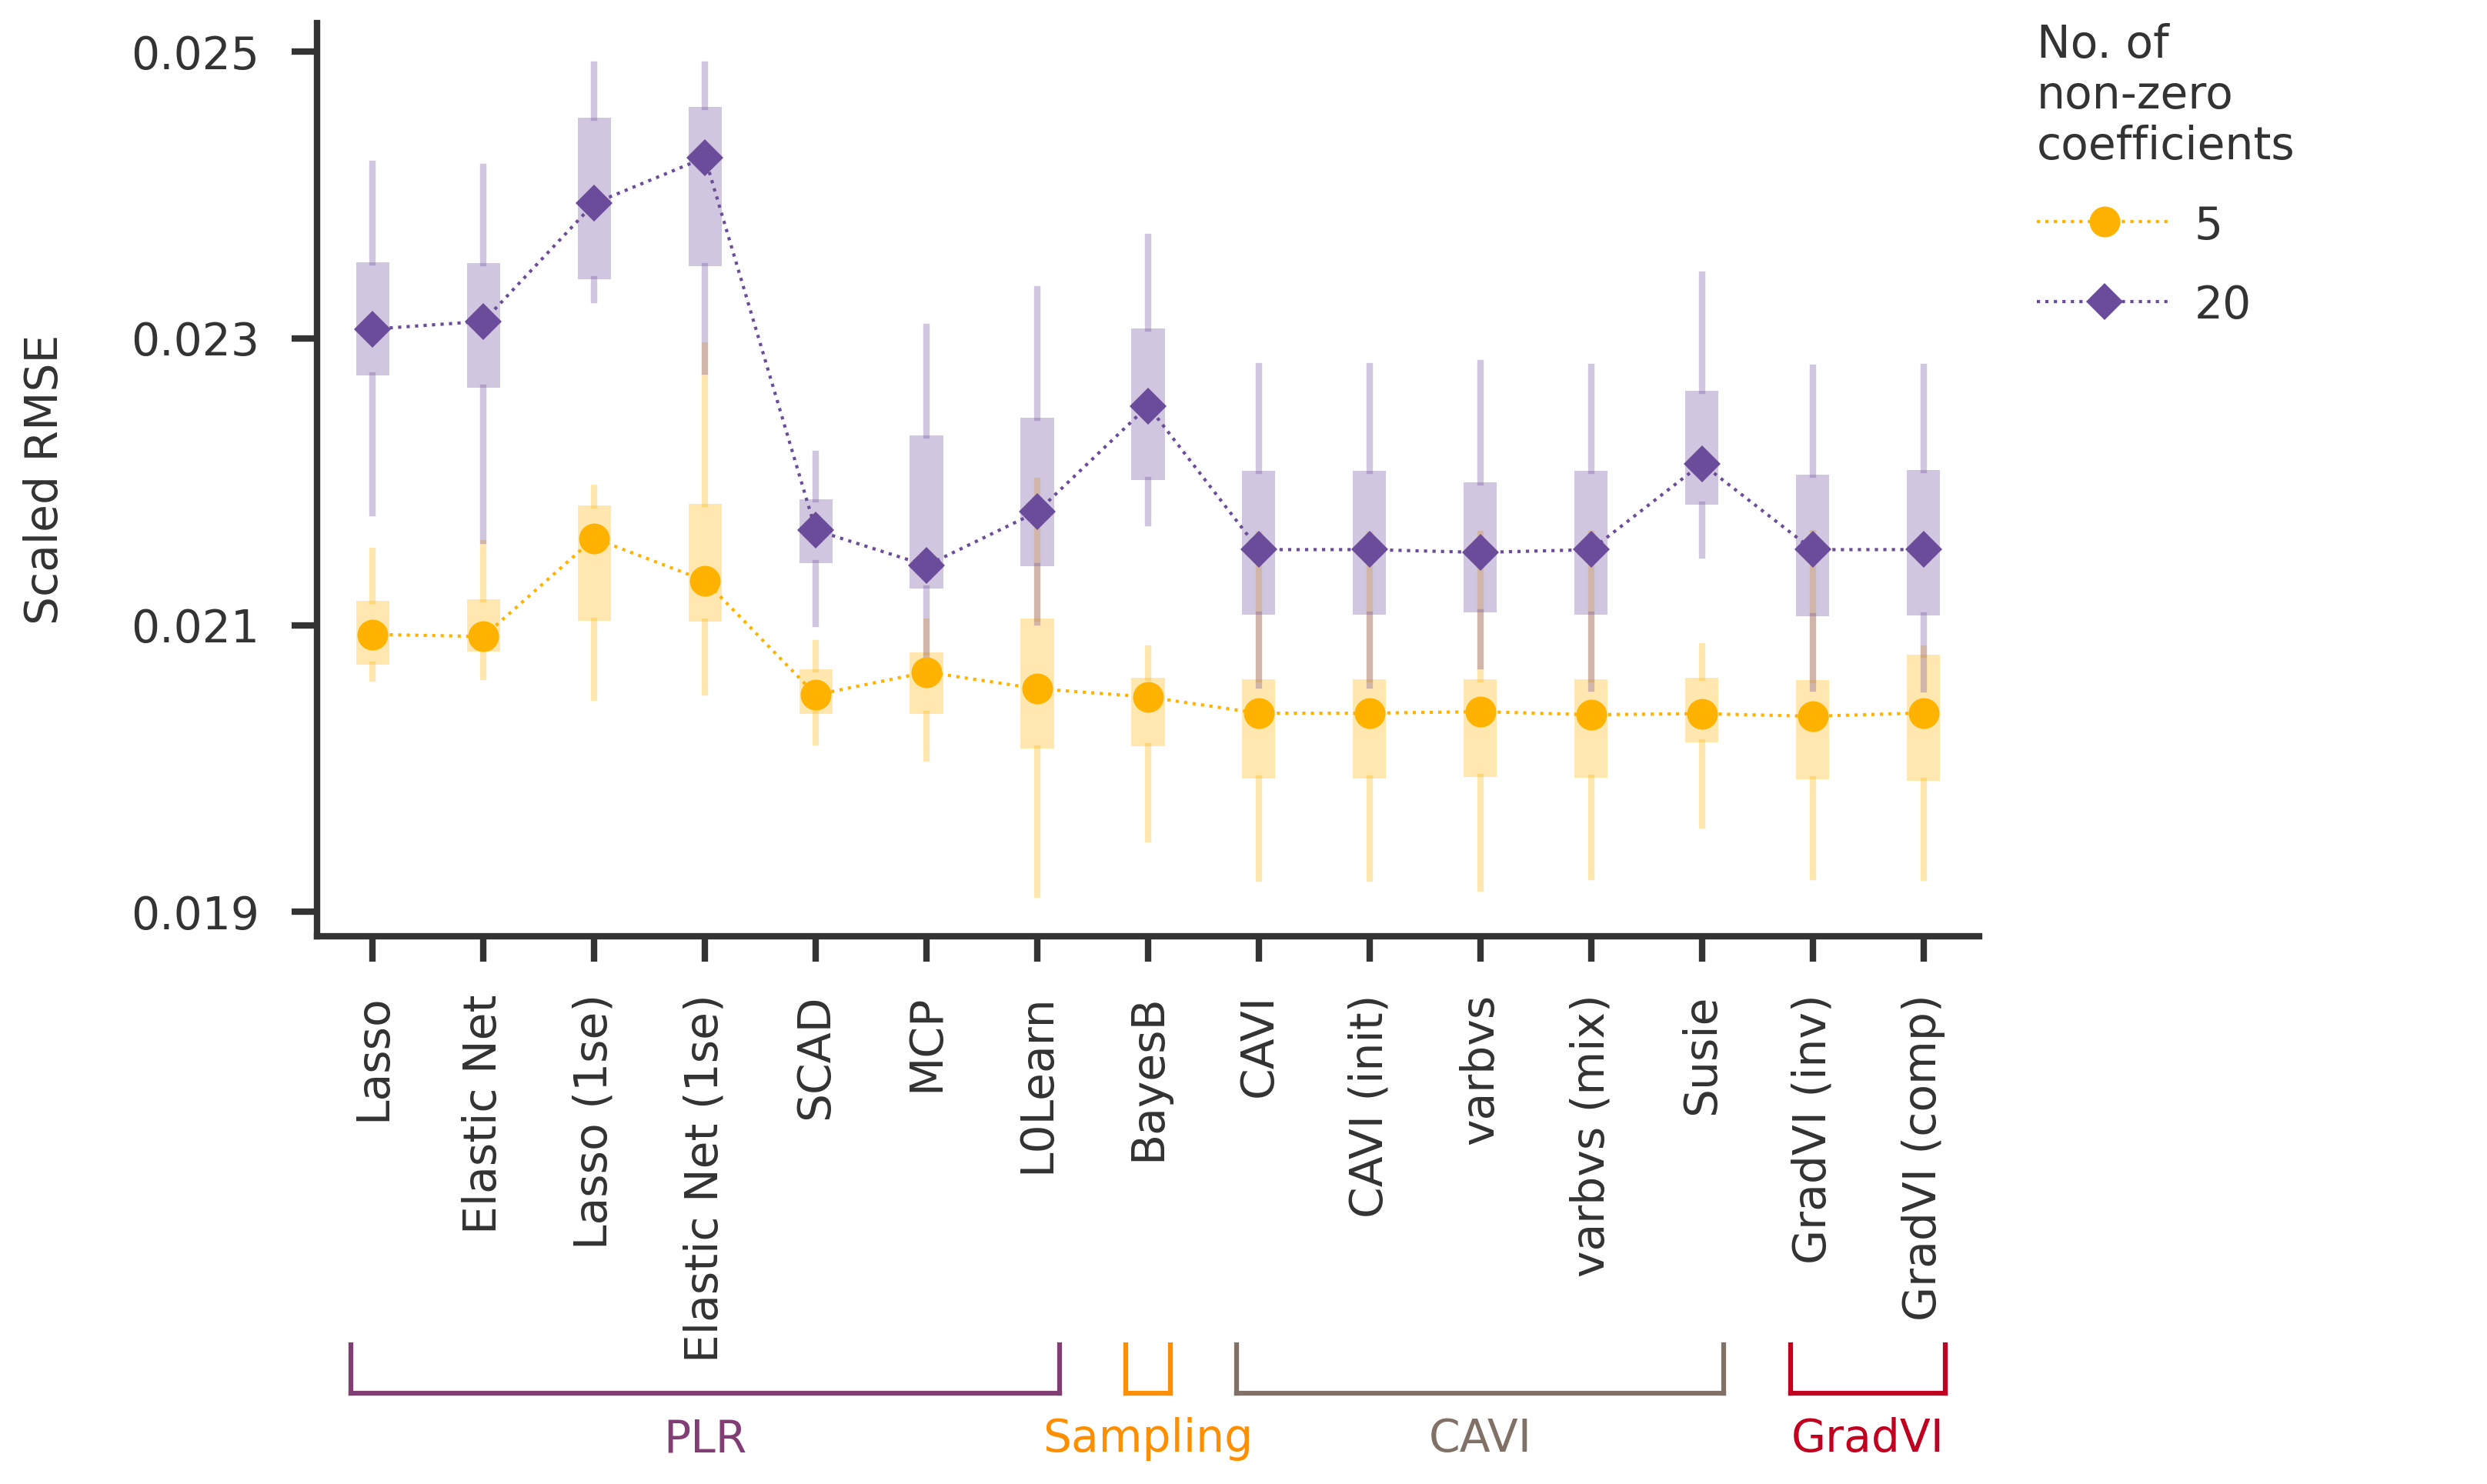

In [10]:
import collections

def saveplot(fig, fileprefix, plotdir = "."):
    for ext in ['pdf', 'png']:
        fl = f"{plotdir}/{fileprefix}.{ext}"
        fig.savefig(fl, bbox_inches = 'tight')
    return

class PlotInfo(collections.namedtuple('PLOT_FIELDS', 
               ['color', 'label', 'marker', 'size'])):
    __slots__ = ()
    
class LabelInfo(collections.namedtuple('LABEL_FIELDS', 
               ['color', 'label'])):
    __slots__ = ()
    
sfix_props = {
    1  : PlotInfo(color = '#93AA00', label = '1',  marker = '^', size = 1.1),
    2  : PlotInfo(color = '#2D69C4', label = '2',  marker = 'v', size = 1),
    5  : PlotInfo(color = '#FFB300', label = '5',  marker = 'o', size = 1.2),
    10 : PlotInfo(color = '#CC2529', label = '10', marker = 's', size = 1.2),
    20 : PlotInfo(color = '#6B4C9A', label = '20', marker = 'D', size = 1)
}

group_props = {
    'PLR'      : LabelInfo(color = '#803E75', label = 'PLR'), 
    'Sampling' : LabelInfo(color = '#FF8E00', label = 'Sampling'), 
    'CAVI'     : LabelInfo(color = '#817066', label = 'CAVI'), 
    'GradVI'   : LabelInfo(color = '#C10020', label = 'GradVI')
}

figw = 12
figh = 8
debugmode = False
savemode  = False
showfliers = False
showboxplot = True
yscale = 'linear'

fig = plt.figure(figsize = (figw, figh))
#axdummy = fig.add_subplot(111)
#ax1     = fig.add_subplot(111)
gs      = fig.add_gridspec(ncols = 2, nrows = 2, width_ratios = [3.5, 1], height_ratios = [1.9, 1])
gs.update(wspace = 0.01, hspace = 0.0) # set the spacing between axes. 
ax2 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[0, 0])
leg_ax = fig.add_subplot(gs[:, 1])

resdf = stratify_dfcol(dscout, 'simulate.pve', 0.6)

#for i, s in enumerate(sfixs):
for i, s in enumerate([5, 20]):
    pinfo = sfix_props[s]
    dfm = stratify_dfcol(resdf, 'simulate.sfix', s)
    
    # boxplot input x
    # If a 2D array, a boxplot is drawn for each column in x. 
    # If a sequence of 1D arrays, a boxplot is drawn for each array in x.
    scores = np.array([score_factory(stratify_dfcol(dfm, 'fit', method)) for method in methods]).T
    
    # Marker and dotted line for the median score of each method
    ax1.plot(
        np.arange(len(methods)), 
        mpl_utils.scale_array(np.median(scores, axis = 0), yscale), 
        label = pinfo.label, color = pinfo.color, lw = 1, 
        ls = 'dotted', marker = pinfo.marker, ms = pinfo.size * 8,
        mec = pinfo.color, mfc = pinfo.color, mew = 0,
        zorder = (i + 1) * 10)
    
    #ax1.axhline(y = np.log10(median_scores[-1]),
    #            zorder = 0, lw = 1, color = 'gainsboro')
    
    # Box plot for each method
    if showboxplot:
        boxcolor = pinfo.color
        boxface = f'#{boxcolor[1:]}50' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
        medianprops = dict(linewidth=0, color = boxcolor)
        whiskerprops = dict(linewidth=2, color = boxface)
        boxprops = dict(linewidth=0, color = boxface, facecolor = boxface)
        flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)

        ax1.boxplot(mpl_utils.scale_array(scores, yscale), 
                    positions = np.arange(len(methods)),
                    showcaps = False, showfliers = showfliers, 
                    widths = 0.3, patch_artist = True, notch = False,
                    zorder = (i + 1),
                    flierprops = flierprops, boxprops = boxprops, 
                    medianprops = medianprops, whiskerprops = whiskerprops)

    
    
ax1.set_xticks(np.arange(len(methods)))
mpl_utils.set_yticks(ax1, scale = yscale, spacing = 'linear', fmt = '{:.3f}')

method_labels = [methodprops.plot_metainfo()[x].label for x in methods]
ax1.set_xticklabels(method_labels)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    #tick.set_ha('right')
ax1.set_ylabel("Scaled RMSE")
    
    
# Remove all axis labels and ticks from the spaceholder axes
for ax in [ax2, leg_ax]:
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)

if not debugmode:
    # remove borders of helper axes (xr)
    for side, border in list(ax2.spines.items()) + \
                        list(leg_ax.spines.items()):
        border.set_visible(False)
        
    for side, border in list(ax1.spines.items()):
        if side in ['top', 'right']:
            border.set_visible(False)

    # make plots transparent
    for ax in [ax1, ax2, leg_ax]:
        ax.set_facecolor('None')
else:
    fig.set_facecolor('turquoise')
    for ax in [ax1, ax2, leg_ax]:
        ax.set_facecolor('beige')
        

# # Using bottom fancy axes
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(0, 1)

gticks = []
gseps = []
gticklabels = []
for key, values in method_groups.items():
    indices = [methods.index(v) for v in values]
    imin = min(indices)
    imax = max(indices)
    gticks.append((imin + imax) / 2.)
    gticklabels.append(key)
    gseps.append((imin, imax))
    y0 = 0.05
    xeps = 0.2
    gcolor = group_props[key].color
    ax2.plot([imin - xeps, imax + xeps], [y0, y0], color = gcolor)
    ax2.axvline(x = imin - xeps, ymin = y0, ymax = y0 + 0.1, color = gcolor)
    ax2.axvline(x = imax + xeps, ymin = y0, ymax = y0 + 0.1, color = gcolor)
    ax2.text((imin + imax) / 2, y0 - 0.05, key, 
             ha = 'center', va = 'top', color = gcolor)

# Legend
mhandles, mlabels = ax1.get_legend_handles_labels()
legend = leg_ax.legend(
    handles = mhandles, labels = mlabels, title = 'No. of\nnon-zero\ncoefficients',
    handlelength = 3, numpoints = 1,
    title_fontproperties={'weight':'normal'},
    loc = 'upper left', bbox_to_anchor = (0.1, 1.0),
    frameon = False, framealpha = 1.0, borderpad = 0.0, borderaxespad = 0.0)
legend._legend_box.align = "left"

if not debugmode:
    if savemode: saveplot(fig, "linreg_indep_rmse_comparison")

plt.show()